In [6]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [2]:
classes = ['class_0','class_1']
class_1_speakers = ['f1','f7','f8','m3','m6','m8']
filepath = 'daps/cleanraw'

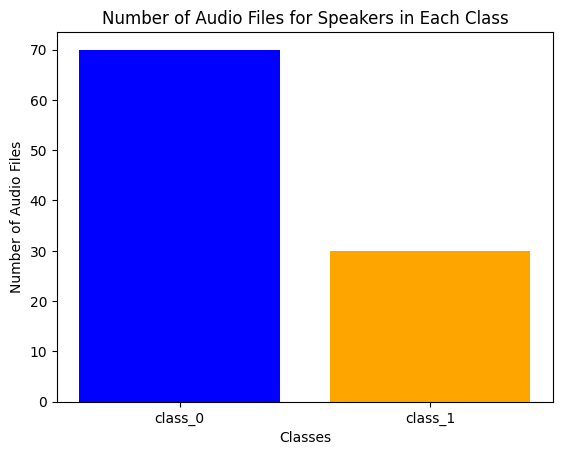

Duration - Mean: 152.9349804988662 Median: 152.40997732426302


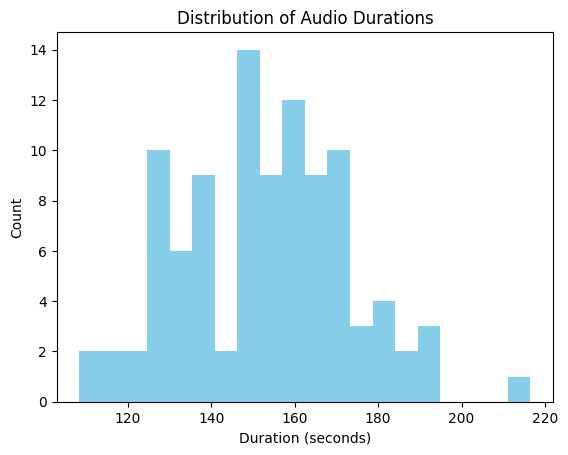

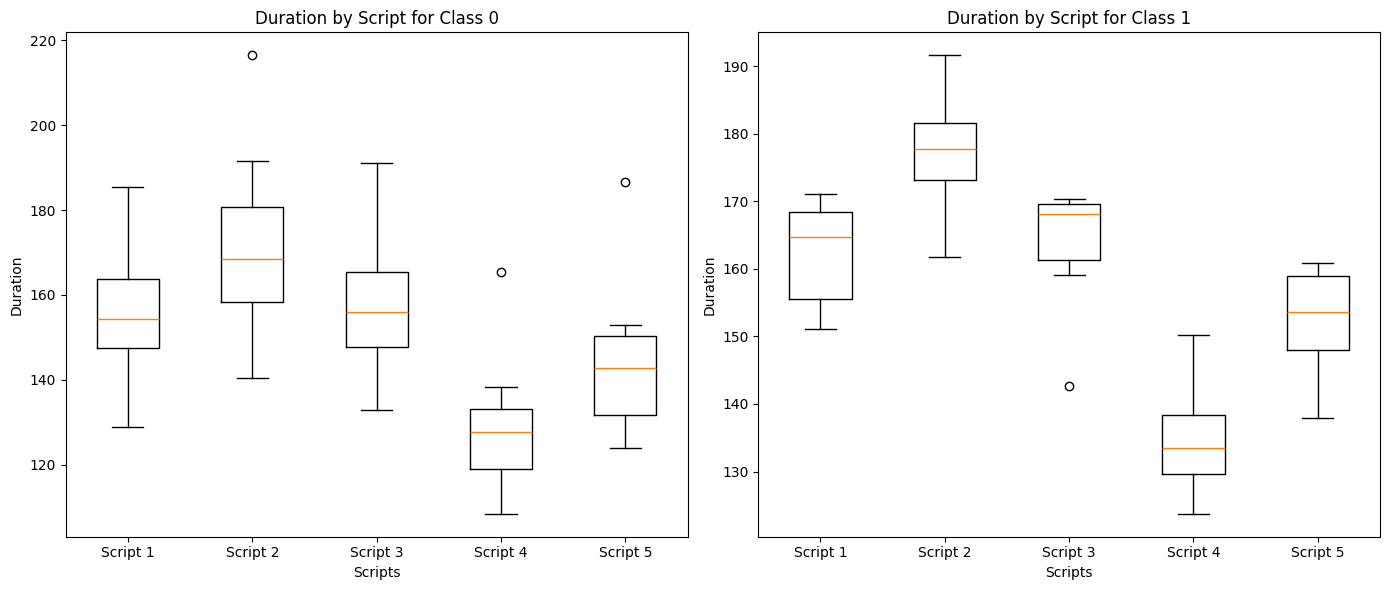

count      100.0
mean     44100.0
std          0.0
min      44100.0
25%      44100.0
50%      44100.0
75%      44100.0
max      44100.0
Name: sample rate, dtype: float64


In [3]:
def EDA():
    data = []

    for file in os.listdir(filepath):
        audio, sr = librosa.load(os.path.join(filepath, file),sr=None)
        trimmed, _ = librosa.effects.trim(audio, top_db=20)  

        data.append({'script': file.split("_")[1], 'speaker': file.split('_')[0], 'class': 'class_1' if file.split('_')[0] in class_1_speakers else 'class_0', 'duration': librosa.get_duration(y=trimmed, sr=sr),'sample rate': sr})

    
    # Plotting
    df = pd.DataFrame(data)

    plt.bar(classes, df['class'].value_counts(), color=['blue', 'orange'])
    plt.xlabel('Classes')
    plt.ylabel('Number of Audio Files')
    plt.title('Number of Audio Files for Speakers in Each Class')
    
    plt.show()

    print("Duration - Mean:", np.mean(df['duration']), "Median:", np.median(df['duration']))

    # Plot duration distribution
    plt.hist(df['duration'], bins=20, color='skyblue')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')
    plt.title('Distribution of Audio Durations')
    plt.show()

    plt.figure(figsize=(14, 6))

    # Boxplot for class_0
    plt.subplot(1, 2, 1)
    plt.boxplot([
        df[(df['script'] == 'script1') & (df['class'] == 'class_0')]['duration'], 
        df[(df['script'] == 'script2') & (df['class'] == 'class_0')]['duration'],
        df[(df['script'] == 'script3') & (df['class'] == 'class_0')]['duration'],
        df[(df['script'] == 'script4') & (df['class'] == 'class_0')]['duration'],
        df[(df['script'] == 'script5') & (df['class'] == 'class_0')]['duration']
    ])
    plt.title('Duration by Script for Class 0')
    plt.xlabel('Scripts')
    plt.ylabel('Duration')
    plt.xticks([1, 2, 3, 4, 5], ['Script 1', 'Script 2', 'Script 3', 'Script 4', 'Script 5'])


    # Boxplot for class_1
    plt.subplot(1, 2, 2)
    plt.boxplot([
        df[(df['script'] == 'script1') & (df['class'] == 'class_1')]['duration'], 
        df[(df['script'] == 'script2') & (df['class'] == 'class_1')]['duration'],
        df[(df['script'] == 'script3') & (df['class'] == 'class_1')]['duration'],
        df[(df['script'] == 'script4') & (df['class'] == 'class_1')]['duration'],
        df[(df['script'] == 'script5') & (df['class'] == 'class_1')]['duration']
    ])
    plt.title('Duration by Script for Class 1')
    plt.xlabel('Scripts')
    plt.ylabel('Duration')
    plt.xticks([1, 2, 3, 4, 5], ['Script 1', 'Script 2', 'Script 3', 'Script 4', 'Script 5'])

    plt.tight_layout()  # Adjust layout
    plt.show()
    
    print(df['sample rate'].describe())


EDA()

### As we can see from the plot, the dataset is imbalanced. To address that we need to implement data augmentation

In [4]:
sample_rate = 44100

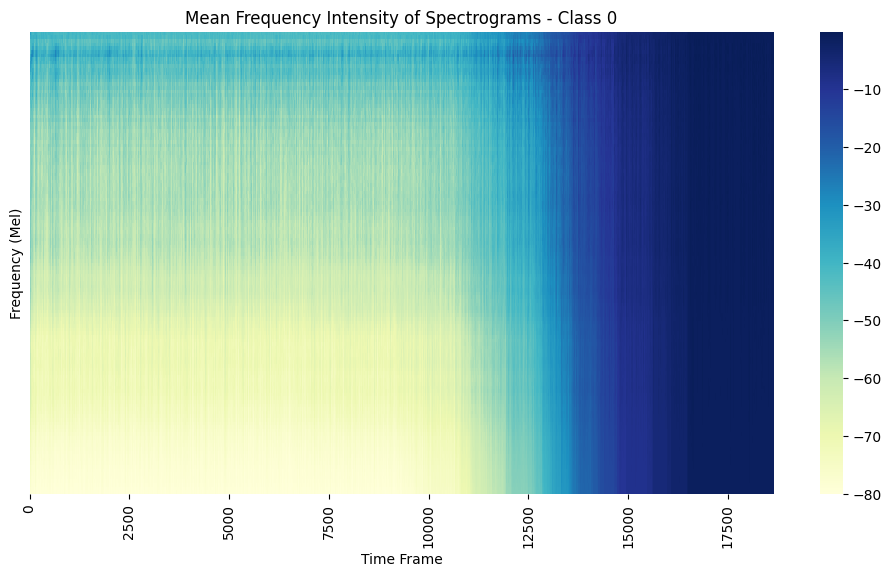

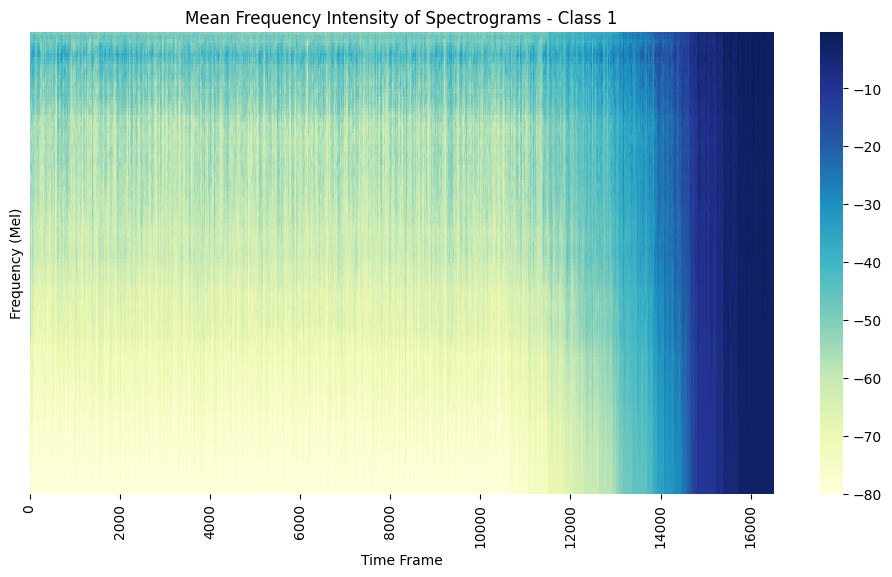

In [7]:
def plot_frequency_intensity(filepath, class_1_speakers):
    class_0_spectrograms = []
    class_1_spectrograms = []

    # Load audio files and compute spectrograms
    for file in os.listdir(filepath):
        audio, sr = librosa.load(os.path.join(filepath, file), sr=None)
        trimmed, _ = librosa.effects.trim(audio, top_db=20)
        S = librosa.feature.melspectrogram(y=trimmed, sr=sr)
        S_dB = librosa.power_to_db(S, ref=np.max)

        if file.split('_')[0] in class_1_speakers:
            class_1_spectrograms.append(S_dB)
        else:
            class_0_spectrograms.append(S_dB)

    # Check if we have any spectrograms for both classes
    if not class_0_spectrograms or not class_1_spectrograms:
        print("Not enough data for one or both classes.")
        return

    # Make sure all spectrograms are of the same length for averaging
    max_length_0 = max(s.shape[1] for s in class_0_spectrograms)
    max_length_1 = max(s.shape[1] for s in class_1_spectrograms)

    padded_class_0 = [np.pad(s, ((0, 0), (0, max_length_0 - s.shape[1])), mode='constant') for s in class_0_spectrograms]
    padded_class_1 = [np.pad(s, ((0, 0), (0, max_length_1 - s.shape[1])), mode='constant') for s in class_1_spectrograms]

    # Calculate the mean spectrogram for each class
    mean_class_0 = np.mean(np.array(padded_class_0), axis=0)  # Shape (n_mels, time)
    mean_class_1 = np.mean(np.array(padded_class_1), axis=0)  # Shape (n_mels, time)

    # Frequency bins corresponding to the mel-spectrogram
    n_mels = mean_class_0.shape[0]  # Number of mel bands
    frequency_bins = librosa.mel_frequencies(n_mels=n_mels, fmin=0, fmax=sr / 2)

    # Create a 2D density plot for Class 0
    plt.figure(figsize=(12, 6))
    sns.heatmap(mean_class_0, cmap='YlGnBu', cbar=True, xticklabels=np.linspace(0, max_length_0, num=10).astype(int), yticklabels=False)
    plt.title('Mean Frequency Intensity of Spectrograms - Class 0')
    plt.xlabel('Time Frame')
    plt.ylabel('Frequency (Mel)')
    plt.xscale('linear')  # Use linear scale
    plt.show()

    # Create a 2D density plot for Class 1
    plt.figure(figsize=(12, 6))
    sns.heatmap(mean_class_1, cmap='YlGnBu', cbar=True, xticklabels=np.linspace(0, max_length_1, num=10).astype(int), yticklabels=False)
    plt.title('Mean Frequency Intensity of Spectrograms - Class 1')
    plt.xlabel('Time Frame')
    plt.ylabel('Frequency (Mel)')
    plt.xscale('linear')  # Use linear scale
    plt.show()

plot_frequency_intensity(filepath, class_1_speakers)

Class 0 spectrograms count: 70
Class 1 spectrograms count: 30
Mean Class 0 shape: (128, 18647)
Mean Class 1 shape: (128, 18647)
Time shape: (18647,)
Mean Class 0 reduced shape: (18647,)
Mean Class 1 reduced shape: (18647,)


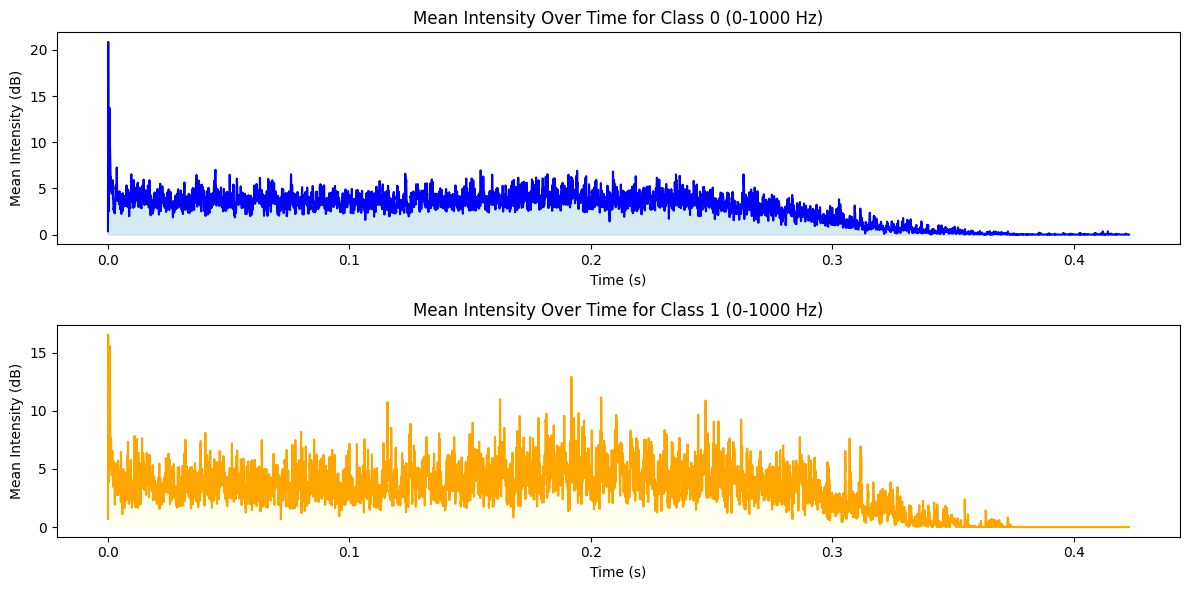

In [8]:
def plot_temporal_intensity(filepath, class_1_speakers):
    class_0_spectrograms = []
    class_1_spectrograms = []
    
    # Load and compute spectrograms
    for file in os.listdir(filepath):
        audio, sr = librosa.load(os.path.join(filepath, file), sr=None)
        trimmed, _ = librosa.effects.trim(audio, top_db=20)
        S = librosa.feature.melspectrogram(y=trimmed, sr=sr)
        
        if file.split('_')[0] in class_1_speakers:
            class_1_spectrograms.append(S)
        else:
            class_0_spectrograms.append(S)

    # Check shapes of loaded spectrograms
    print(f"Class 0 spectrograms count: {len(class_0_spectrograms)}")
    print(f"Class 1 spectrograms count: {len(class_1_spectrograms)}")

    # Pad or truncate spectrograms to ensure consistent shapes
    def pad_spectrograms(spectrograms, max_length):
        padded = []
        for s in spectrograms:
            if s.shape[1] < max_length:
                # Pad with zeros on the right
                padded_s = np.pad(s, ((0, 0), (0, max_length - s.shape[1])), mode='constant')
            else:
                # Truncate to max_length
                padded_s = s[:, :max_length]
            padded.append(padded_s)
        return padded

    max_length_class_0 = max(s.shape[1] for s in class_0_spectrograms) if class_0_spectrograms else 0
    max_length_class_1 = max(s.shape[1] for s in class_1_spectrograms) if class_1_spectrograms else 0
    max_length = max(max_length_class_0, max_length_class_1)

    class_0_spectrograms_padded = pad_spectrograms(class_0_spectrograms, max_length)
    class_1_spectrograms_padded = pad_spectrograms(class_1_spectrograms, max_length)

    # Calculate mean spectrogram over time for each class
    mean_class_0 = np.mean(class_0_spectrograms_padded, axis=0)
    mean_class_1 = np.mean(class_1_spectrograms_padded, axis=0)

    # Print shapes of mean spectrograms
    print(f"Mean Class 0 shape: {mean_class_0.shape}")
    print(f"Mean Class 1 shape: {mean_class_1.shape}")

    # Calculate average intensity for a specific frequency band (e.g., 0-1000 Hz)
    frequency_bins = librosa.mel_frequencies(n_mels=mean_class_0.shape[0])
    
    # You can choose the frequency range you want to visualize
    freq_range_indices = frequency_bins <= 1000
    mean_class_0_reduced = mean_class_0[freq_range_indices, :].mean(axis=0)  # Average over frequency
    mean_class_1_reduced = mean_class_1[freq_range_indices, :].mean(axis=0)

    # Time axis based on the number of frames in the mean spectrogram
    time = np.linspace(0, max_length / sr, mean_class_0.shape[1])  # Time for each frame

    # Print shapes for debugging
    print(f"Time shape: {time.shape}")
    print(f"Mean Class 0 reduced shape: {mean_class_0_reduced.shape}")
    print(f"Mean Class 1 reduced shape: {mean_class_1_reduced.shape}")

    # Ensure that the time array matches the number of time frames
    time = time[:mean_class_0_reduced.shape[0]]

    # Plot
    plt.figure(figsize=(12, 6))
    
    # Class 0
    plt.subplot(2, 1, 1)
    plt.plot(time, mean_class_0_reduced, label='Mean Intensity (Class 0)', color='blue')
    plt.fill_between(time, mean_class_0_reduced, color='lightblue', alpha=0.5)
    plt.title('Mean Intensity Over Time for Class 0 (0-1000 Hz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Mean Intensity (dB)')
    
    # Class 1
    plt.subplot(2, 1, 2)
    plt.plot(time, mean_class_1_reduced, label='Mean Intensity (Class 1)', color='orange')
    plt.fill_between(time, mean_class_1_reduced, color='lightyellow', alpha=0.5)
    plt.title('Mean Intensity Over Time for Class 1 (0-1000 Hz)')
    plt.xlabel('Time (s)')
    plt.ylabel('Mean Intensity (dB)')

    plt.tight_layout()
    plt.show()

# Example usage
plot_temporal_intensity(filepath, class_1_speakers)

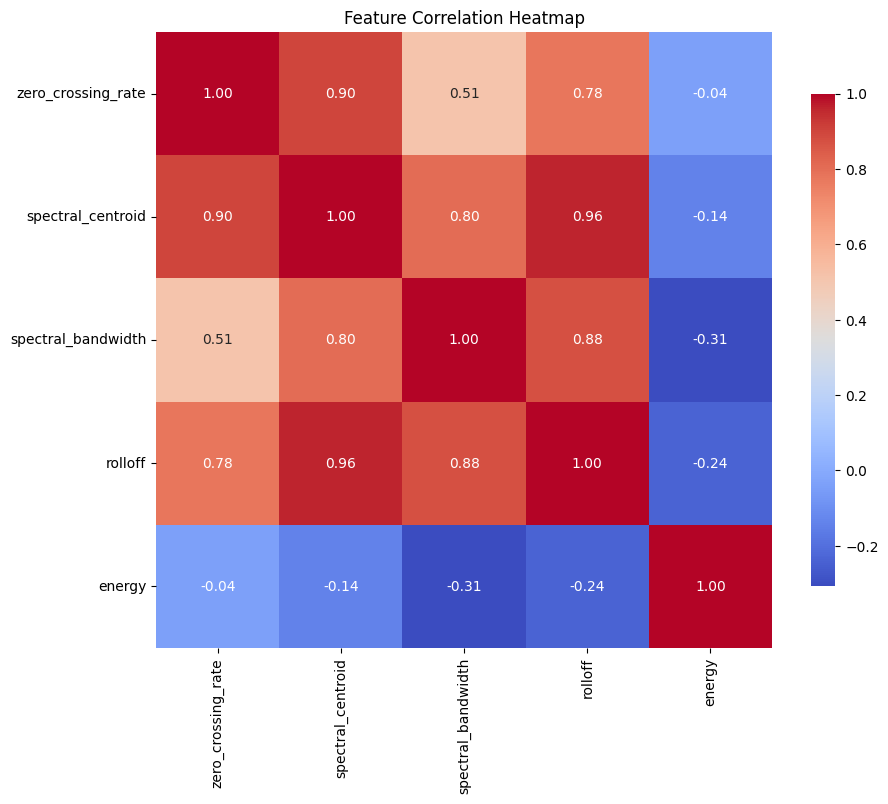

In [9]:
def extract_features(filepath, class_1_speakers):
    features_list = []

    # Load and compute features
    for file in os.listdir(filepath):
        audio, sr = librosa.load(os.path.join(filepath, file), sr=None)
        
        # Calculate features
        zcr = librosa.feature.zero_crossing_rate(audio).mean()
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr).mean()
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr).mean()
        rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85).mean()
        energy = np.sum(librosa.feature.rms(y=audio))

        # Store features in a dictionary
        features = {
            'filename': file,
            'class': 'Class 1' if file.split('_')[0] in class_1_speakers else 'Class 0',
            'zero_crossing_rate': zcr,
            'spectral_centroid': spectral_centroid,
            'spectral_bandwidth': spectral_bandwidth,
            'rolloff': rolloff,
            'energy': energy
        }
        features_list.append(features)

    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)
    return features_df

def plot_correlation_heatmap(features_df):
    # Select only numeric columns for correlation
    numeric_features_df = features_df.select_dtypes(include=[np.number])
    
    # Compute the correlation matrix
    correlation_matrix = numeric_features_df.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Heatmap')
    plt.show()

    
# Extract features
features_df = extract_features(filepath, class_1_speakers)

# Plot the correlation heatmap
plot_correlation_heatmap(features_df)


### Audio Features

1. **Zero Crossing Rate (ZCR)**:
   - **Definition**: This measures the rate at which the signal changes sign (i.e., crosses the zero line) within a specific frame or window. It is essentially a count of how often the signal goes from positive to negative or vice versa.
   - **Interpretation**: ZCR is commonly associated with the noisiness or percussive nature of a signal. Higher ZCR values indicate more frequent sign changes and, thus, a more "noisy" or "percussive" sound (like fricatives or certain consonants in speech). Lower values are typical of smoother or more tonal sounds.
   
2. **Spectral Centroid**:
   - **Definition**: The spectral centroid indicates the "center of mass" of the spectrum, essentially summarizing where the "center" of the frequencies lies within each frame. It’s calculated as a weighted mean of the frequencies, weighted by their magnitudes.
   - **Interpretation**: Spectral centroid is often associated with the perceived brightness of a sound. Higher spectral centroid values generally correspond to brighter, sharper sounds (e.g., consonants or high-pitched instruments), while lower values correspond to darker, warmer sounds (e.g., vowels or bass sounds).

3. **Spectral Bandwidth**:
   - **Definition**: This feature measures the width of the spectrum, providing an estimate of the range of frequencies around the spectral centroid. The second-order spectral bandwidth (used here) is calculated as the standard deviation of the frequencies around the spectral centroid.
   - **Interpretation**: Higher spectral bandwidth values are associated with richer or more complex sounds that contain a broader range of frequencies. Lower values indicate simpler sounds with more focused frequency content.

4. **Spectral Contrast**:
   - **Definition**: Spectral contrast measures the difference in amplitude between peaks and valleys in the sound spectrum. It is computed for different frequency bands and can indicate how varied the energy distribution is within the audio.
   - **Interpretation**: Higher spectral contrast values indicate a more pronounced difference between peaks and valleys, often characteristic of complex sounds with distinct tonal and noise components. Lower values indicate a more even energy distribution.

5. **Spectral Rolloff**:
   - **Definition**: The spectral rolloff point is the frequency below which a certain percentage (e.g., 85%) of the total spectral energy lies. It’s a measure of the shape of the spectral distribution.
   - **Interpretation**: Higher rolloff values indicate that more energy is concentrated in the higher frequency range, characteristic of brighter sounds. Lower rolloff values are typical of sounds with more energy in the lower frequencies.

6. **Mel-frequency Cepstral Coefficients (MFCCs)**:
   - **Definition**: MFCCs represent the short-term power spectrum of a sound, computed using the Mel scale, which is designed to match the human ear's perception of sound frequencies. Each coefficient provides information about different aspects of the spectral envelope.
   - **Interpretation**: MFCCs are widely used in speech and audio processing because they capture the timbral qualities of sound in a way that approximates human auditory perception. They are essential for distinguishing different types of sounds, especially in speech processing.

### Why These Features?

Each of these features captures distinct aspects of the audio signal, such as frequency content, energy distribution, and perceptual characteristics. By analyzing correlations between these features, you can observe how they relate to one another. For instance, a high correlation between spectral centroid and spectral rolloff would suggest that as the "brightness" of a sound increases, so does the proportion of energy in higher frequencies.

Together, these features provide a holistic view of the characteristics of the audio signal, allowing for nuanced analysis and better classification or recognition of the sound sources. Let me know if you'd like any further clarification on these features or how to analyze them!